Поработаем с [данными](https://github.com/obulygin/content/blob/main/possum_data/possum.csv) по физиологическим показателям поссумов

## Импорты библиотек и получение данных

In [ ]:
!pip install phik
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import phik
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.metrics import classification_report, confusion_matrix, f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('https://github.com/obulygin/content/raw/main/possum_data/possum.csv').drop(['site', 'Unnamed: 0'], axis=1)

Переведём таргет в бинарный вид:

In [ ]:
df.replace({'f':0, 'm':1},inplace=True)
df

,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...
99,1,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,1,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,0,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,1,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


## Подготовка данных

Проверим наличие дублей:

In [ ]:
df.duplicated().sum()

np.int64(0)

Дублей нет.

In [ ]:
data_origin = df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       104 non-null    int64  
 1   age       102 non-null    float64
 2   hdlngth   104 non-null    float64
 3   skullw    104 non-null    float64
 4   totlngth  104 non-null    float64
 5   taill     104 non-null    float64
 6   footlgth  103 non-null    float64
 7   earconch  104 non-null    float64
 8   eye       104 non-null    float64
 9   chest     104 non-null    float64
 10  belly     104 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.1 KB


Видим пропуски в 'age' и 'footlgth'. Заполним пропуски медианными значениями по столбцу для пола зверя.

In [ ]:
df['footlgth'].fillna(df.groupby('sex')['footlgth'].transform('median'), inplace=True)
df['age'].fillna(df.groupby('sex')['age'].transform('median'), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       104 non-null    int64  
 1   age       104 non-null    float64
 2   hdlngth   104 non-null    float64
 3   skullw    104 non-null    float64
 4   totlngth  104 non-null    float64
 5   taill     104 non-null    float64
 6   footlgth  104 non-null    float64
 7   earconch  104 non-null    float64
 8   eye       104 non-null    float64
 9   chest     104 non-null    float64
 10  belly     104 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.1 KB


## EDA

Начнём со взаимосвязями признаков:

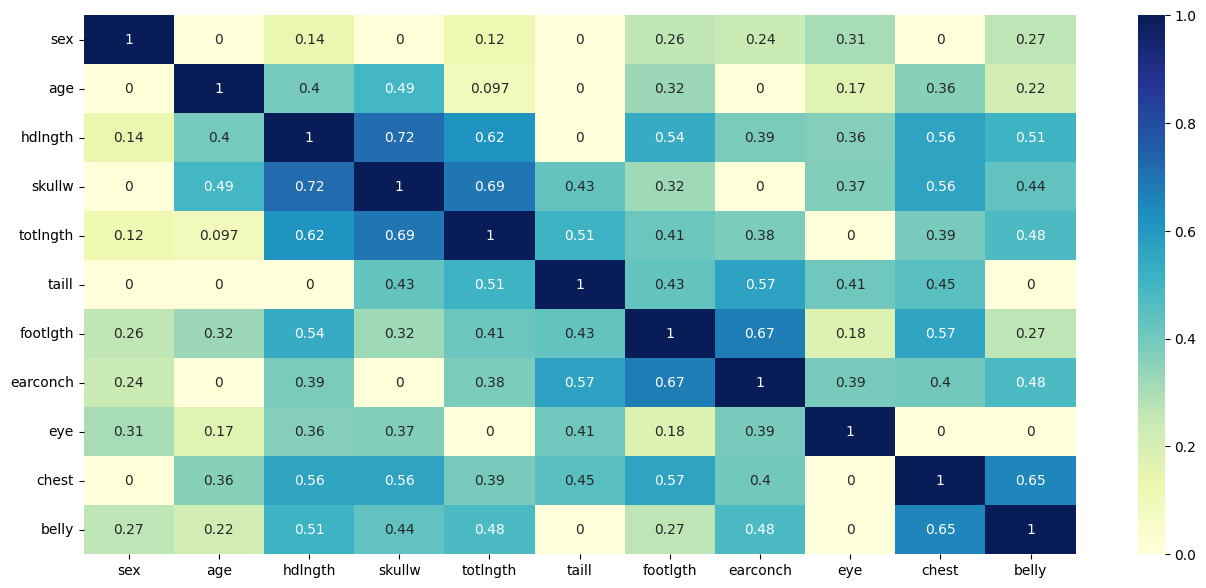

In [ ]:
plt.figure(figsize=(16, 7))
sns.heatmap(phik.phik_matrix(data_origin, interval_cols=data_origin.columns.tolist()), annot=True, cmap='YlGnBu')
plt.show()

Мультиколлинеарности нет. Сильно выраженной корреляции к таргету ни у одного признаков нет. Есть отсутствие корреляции к таргету у некоторых признаков, имеет смысл попробовать использование модели на данных без этих признаков.

Построим гистограмму распределения с разбивкой по таргету:

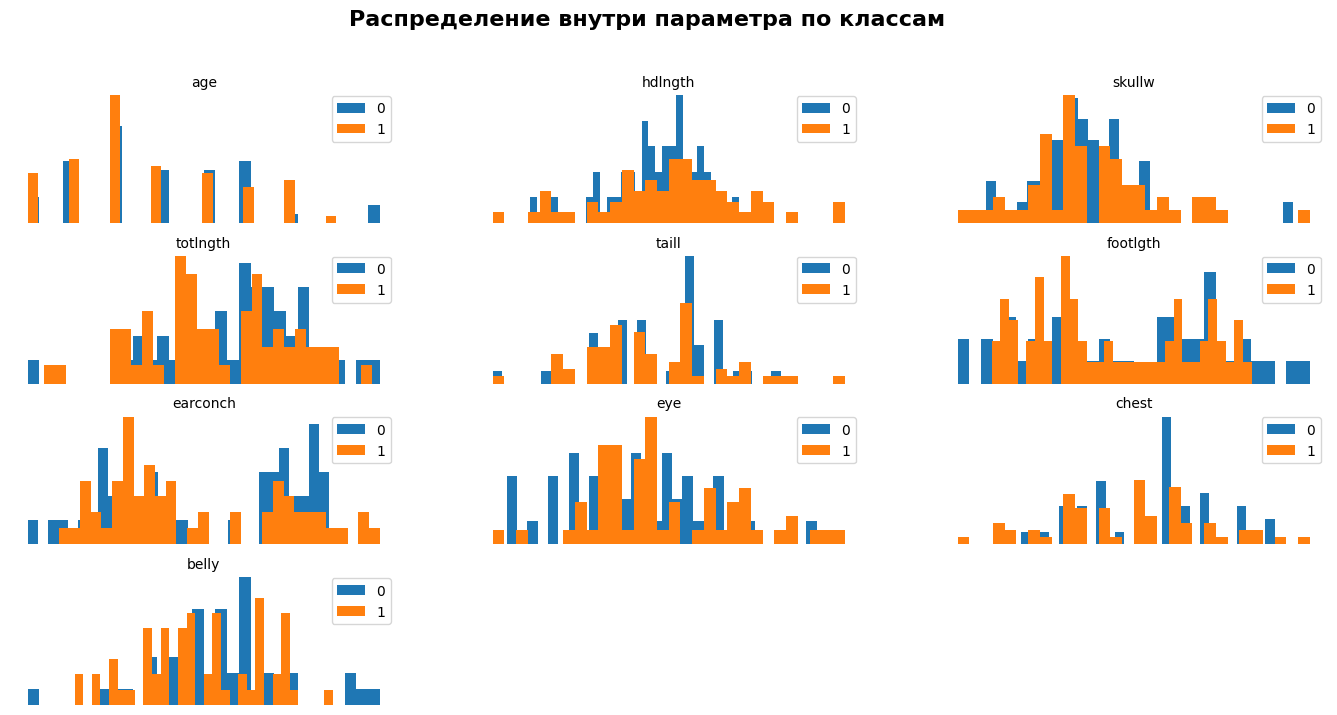

In [ ]:
cols = df.drop('sex', axis=1).columns.tolist()
plt.figure(figsize=(17, 8))
plt.suptitle('Распределение внутри параметра по классам', fontsize=16, fontweight='bold')
for i, col in enumerate(cols):
  plt.subplot(4, 3, i+1)
  df.groupby('sex')[col].plot(kind='hist', density = True, bins = 30)
  plt.title(f'{col}', fontsize=10, verticalalignment='top')
  plt.legend()
  plt.grid(True)
  plt.axis('off')

plt.show()

Большая часть признаков не имеет нормального распределения и по отношению к таргету оно отличается.

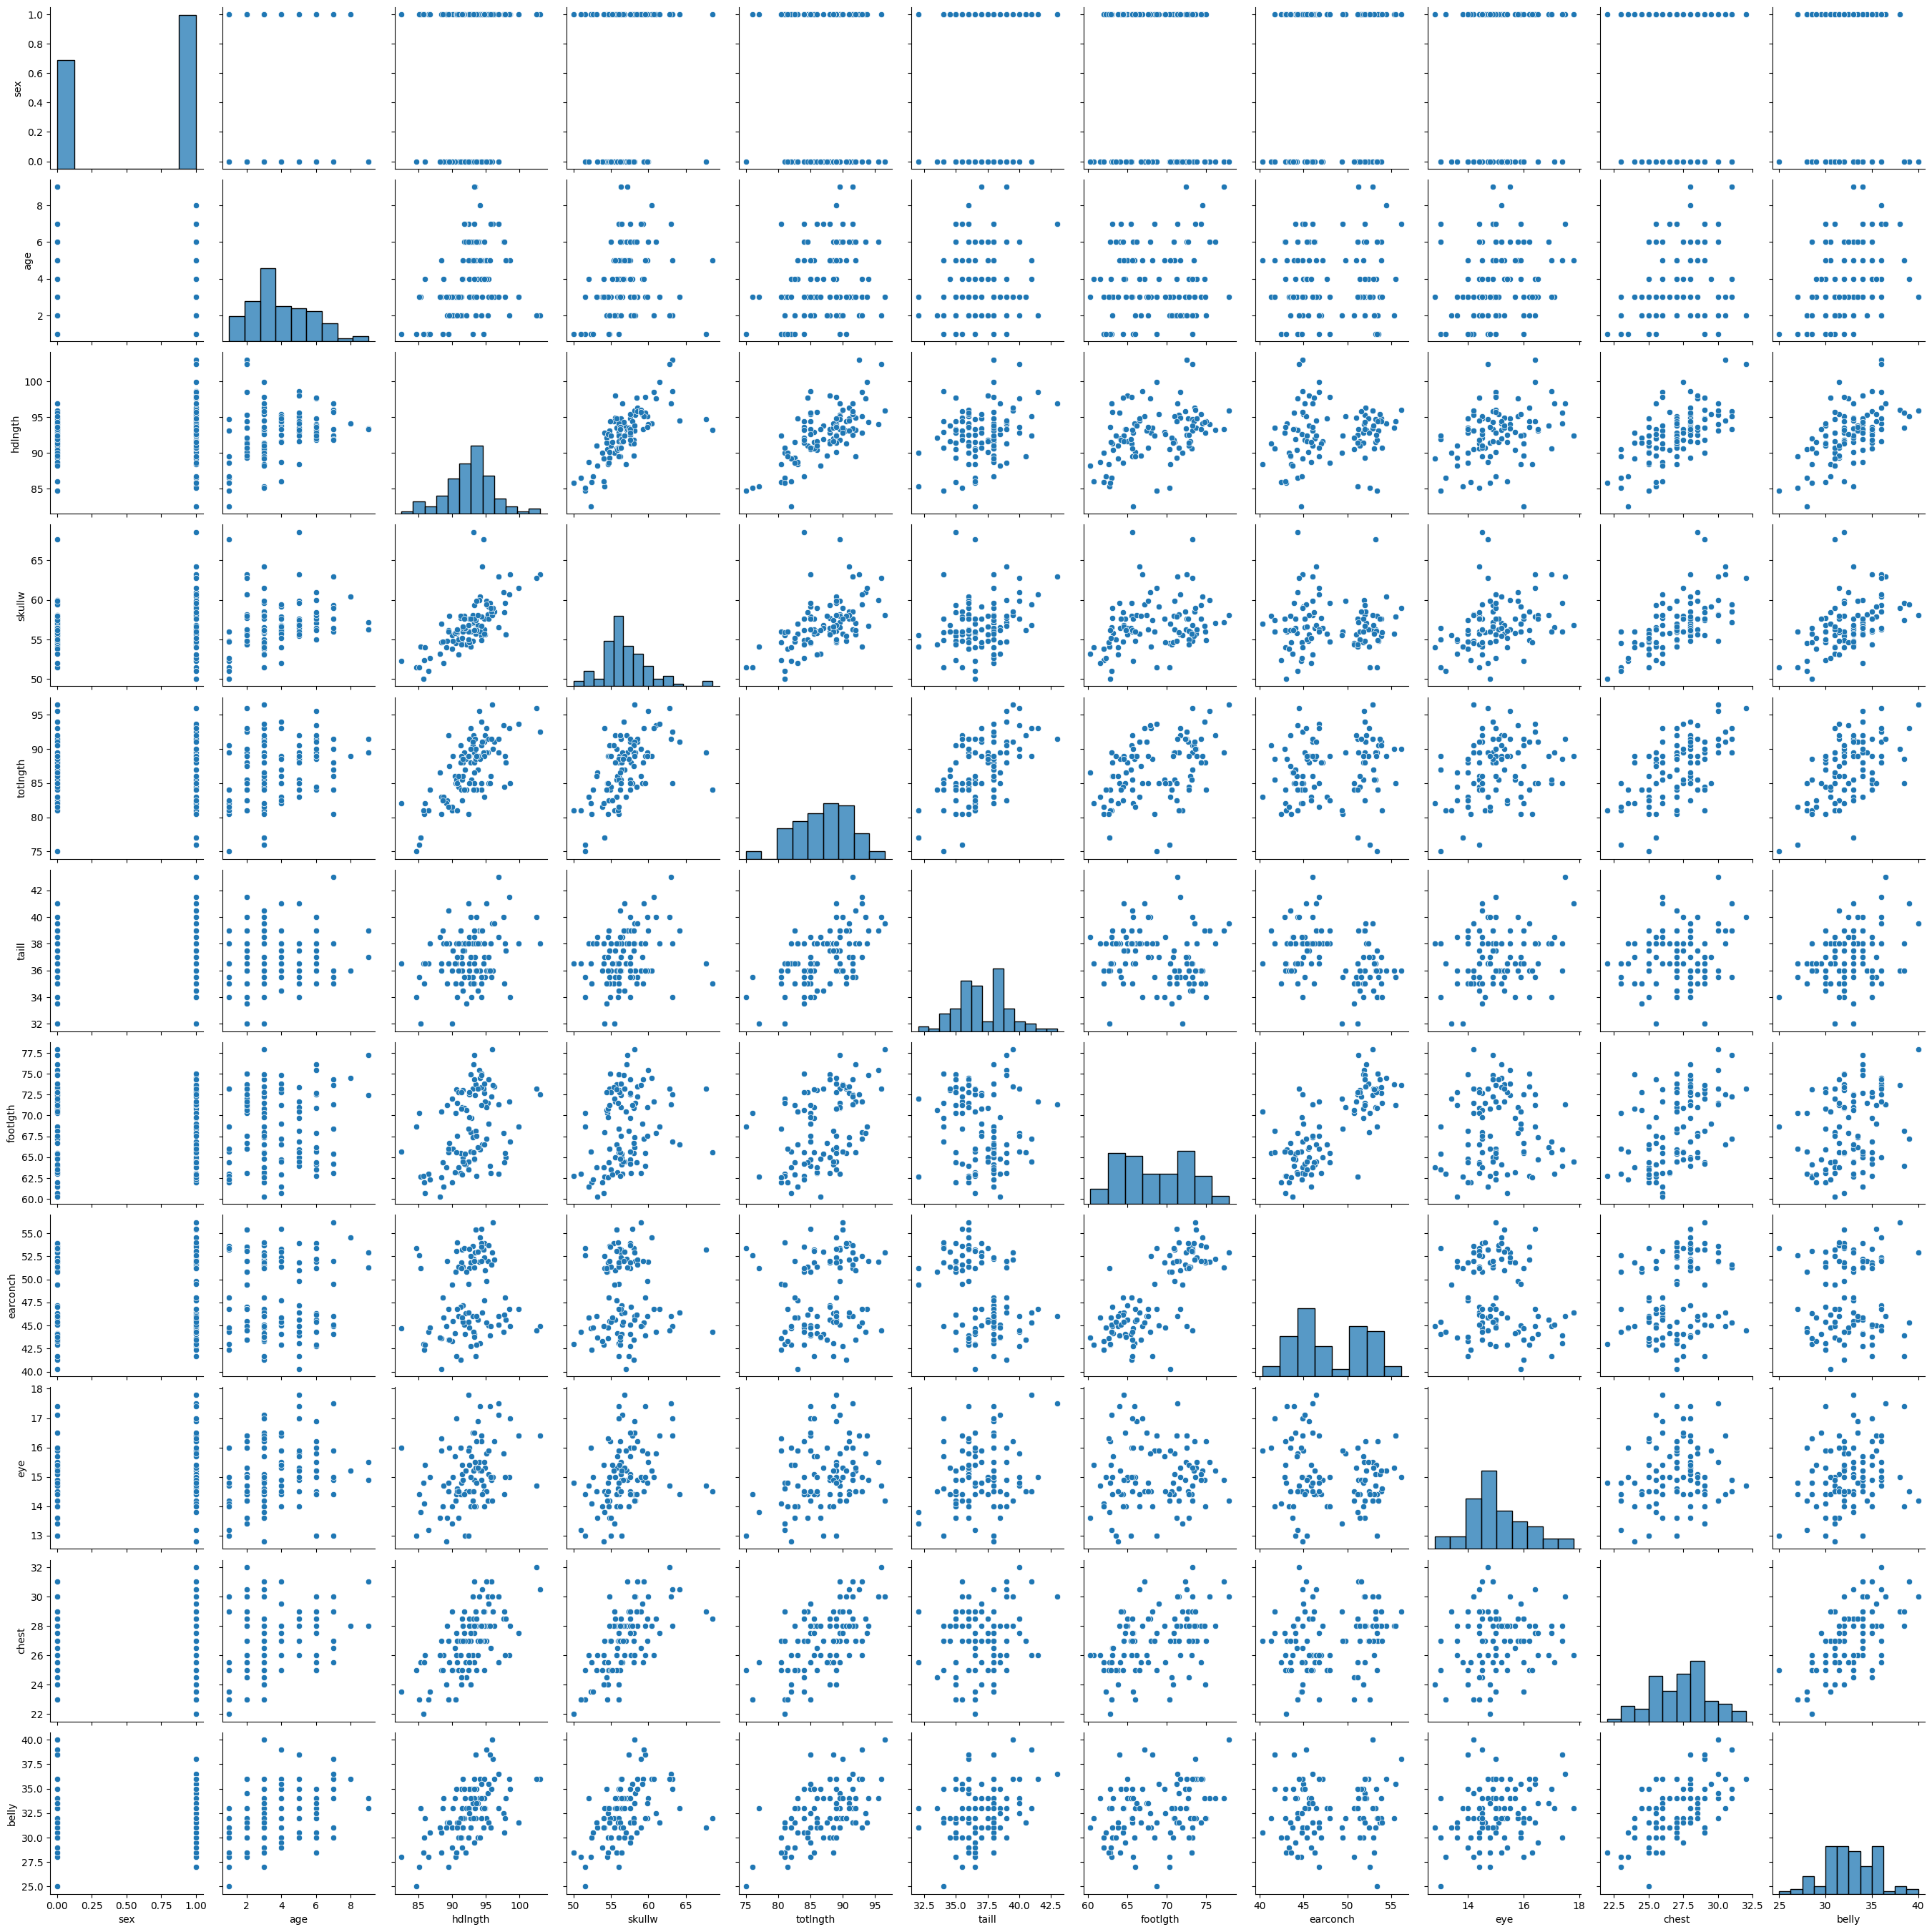

In [ ]:
sns.pairplot(df)

У части признаков имеется похожая на линейную зависимость, часть признаков имеет группирующиеся данные, у остальных более сложные типы взаимосвязи.

Посмотрим на выбросы.

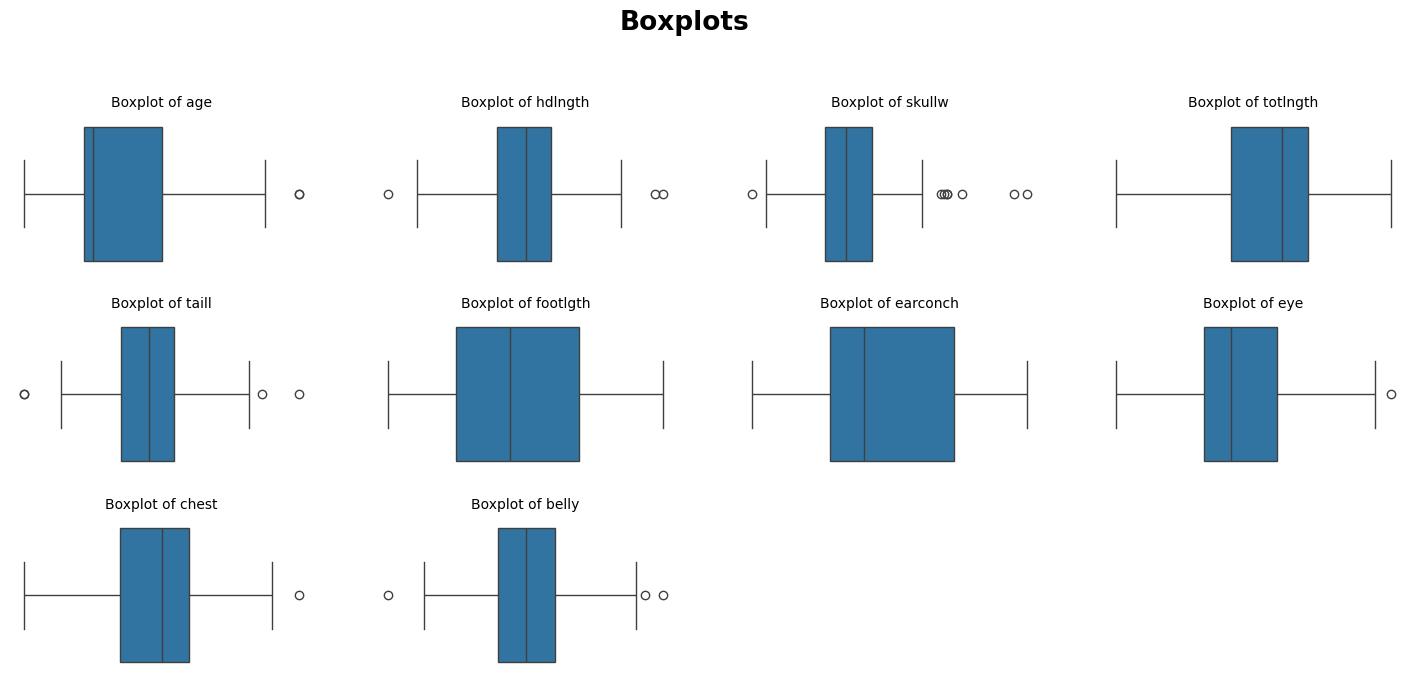

In [ ]:
cols = data_origin.drop('sex', axis=1).columns.tolist()
plt.figure(figsize=(18, 10))
plt.suptitle('Boxplots', fontsize=19, fontweight='bold')
for i, col in enumerate(cols):
  plt.subplot(4, 4, i+1)
  sns.boxplot(x=data_origin[col])
  plt.title(f'Boxplot of {col}', fontsize=10, verticalalignment='top')
  plt.axis('off')

plt.show()

Для определения явно ошибочных значений посмотрим описание данных:

In [ ]:
df.describe()

,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.586538,3.817308,92.602885,56.883654,87.088462,37.009615,68.478365,48.130769,15.046154,27.000000,32.586538
std,0.494839,1.894112,3.573349,3.113426,4.310549,1.959518,4.378271,4.109380,1.050374,2.045597,2.761949
min,0.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,0.000000,2.750000,90.675000,54.975000,84.000000,35.875000,64.650000,44.800000,14.400000,25.500000,31.000000
50%,1.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.100000,46.800000,14.900000,27.000000,32.500000
75%,1.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,1.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


Несмотря на выбросы по признакам skullw, hdlngth, belly, taill на боксплотах, судя по описанию данных, ошибочными эти значения не являются и как следствие удалению не подлежат.




Посмотрим на баланс классов:

In [ ]:
df['sex'].value_counts()

,count
sex,
1,61
0,43


Преобладает мужской пол. Попробуем различные методики борьбы с дисбалансом классов.

## Построим модели и замерим их точность метрикой f1_score

Начнем с разделения выборок.

In [ ]:
from sklearn.preprocessing import RobustScaler

X = df.drop('sex', axis=1)
y = df['sex']
y = y.to_numpy()
y = [np.array(label) for label in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)


При построении первой модели подберем гиперпараметры для регуляризации с полиномом и class_weight, сразу определив, что именнно даст хороший результат - взвешивание классов, полином или регуляризация:

In [ ]:
%%time
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
degree_map = [1, 2, 3]
class_weight_map = [None, 'balanced']
penalty_map = [None, 'elasticnet']

space = {
    'logisticregression__C': hp.uniform('logisticregression__C', 0.01, 200),
    'logisticregression__l1_ratio': hp.uniform('logisticregression__l1_ratio', 0, 1),
    'logisticregression__class_weight': hp.choice('logisticregression__class_weight', class_weight_map),
    'logisticregression__penalty': hp.choice('logisticregression__penalty', penalty_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_elasticnet = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

def objective(params):
    pipeline_elasticnet.set_params(logisticregression__C=params['logisticregression__C'],
                        logisticregression__l1_ratio=params['logisticregression__l1_ratio'],
                        logisticregression__class_weight=params['logisticregression__class_weight'],
                        logisticregression__penalty=params['logisticregression__penalty'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_elasticnet, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_elasticnet = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_elasticnet)

100%|██████████| 100/100 [01:08<00:00,  1.46trial/s, best loss: -0.7853041695146958]
Лучшие гиперпараметры: {'logisticregression__C': np.float64(0.9195193469416263), 'logisticregression__class_weight': np.int64(0), 'logisticregression__l1_ratio': np.float64(0.49813724576373664), 'logisticregression__penalty': np.int64(1), 'polynomialfeatures__degree': np.int64(0)}
CPU times: user 3.11 s, sys: 175 ms, total: 3.29 s
Wall time: 1min 8s


Как видно, лучшие параметры с результатом 0.785 по метрике f1_score взвешивание классов в себя не включают, без него модель работает лучше, полином также не дал прироста. А регуляризация сказывается на качестве положительно.

In [ ]:
# зафиксируем результат в словаре results
results = {}

pipeline_elasticnet = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

pipeline_elasticnet.set_params(logisticregression__C=best_elasticnet['logisticregression__C'],
                    logisticregression__l1_ratio=best_elasticnet['logisticregression__l1_ratio'],
                    logisticregression__class_weight=class_weight_map[best_elasticnet['logisticregression__class_weight']],
                    logisticregression__penalty=penalty_map[best_elasticnet['logisticregression__penalty']],
                      polynomialfeatures__degree=degree_map[best_elasticnet['polynomialfeatures__degree']])

cv_metrics = cross_validate(
    pipeline_elasticnet,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results['LR with ElasticNet'] = cv_metrics["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.7853.


Ошибки:

              precision    recall  f1-score   support

           0       0.73      0.50      0.59        32
           1       0.71      0.87      0.78        46

    accuracy                           0.72        78
   macro avg       0.72      0.68      0.69        78
weighted avg       0.72      0.72      0.71        78



<Axes: >

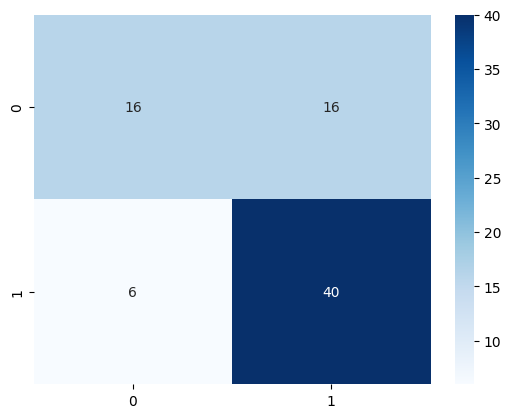

In [ ]:
y_pred = cross_val_predict(pipeline_elasticnet, X_train, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Ошибки распределены неравномерно вследствие дисбаланса классов.

Из проведенных тестов делаем вывод, что наибольшего качества удается достичь при использовании логистической регрессиии с ElasticNet, соответственно на такой модели попробуем применить сэмплирование, начиная с DownSampliing:

In [ ]:
%%time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
degree_map = [1, 2, 3]

space = {
    'logisticregression__C': hp.uniform('logisticregression__C', 0.01, 1000),
    'logisticregression__l1_ratio': hp.uniform('logisticregression__l1_ratio', 0, 1),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_us = make_pipeline(
    RobustScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

def objective(params):
    pipeline_us.set_params(logisticregression__C=params['logisticregression__C'],
                        logisticregression__l1_ratio=params['logisticregression__l1_ratio'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_us, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_us = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_us)

100%|██████████| 100/100 [02:53<00:00,  1.74s/trial, best loss: -0.6723684210526316]
Лучшие гиперпараметры: {'logisticregression__C': np.float64(860.9318726086155), 'logisticregression__l1_ratio': np.float64(0.6082491621711366), 'polynomialfeatures__degree': np.int64(2)}
CPU times: user 4.49 s, sys: 409 ms, total: 4.9 s
Wall time: 2min 55s


In [ ]:
%%time

# зафиксируем результат в словаре results
pipeline_us.set_params(logisticregression__C=best_us['logisticregression__C'],
                    logisticregression__l1_ratio=best_us['logisticregression__l1_ratio'],
                      polynomialfeatures__degree=degree_map[best_us['polynomialfeatures__degree']])

cv_metrics = cross_validate(
    pipeline_us,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results['LR with UnderSampling'] = cv_metrics["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics["test_score"].mean():.4f}.\n')

Среднее качество на валидации: 0.6724.

CPU times: user 39.9 ms, sys: 1.24 ms, total: 41.2 ms
Wall time: 2.28 s


Результат заметно хуже.

Смотрим Upsampling:

In [ ]:
%%time
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
degree_map = [1, 2, 3]

space = {
    'logisticregression__C': hp.uniform('logisticregression__C', 0.01, 200),
    'logisticregression__l1_ratio': hp.uniform('logisticregression__l1_ratio', 0, 1),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_os = make_pipeline(
    RobustScaler(),
    RandomOverSampler(random_state=42),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

def objective(params):
    pipeline_os.set_params(logisticregression__C=params['logisticregression__C'],
                        logisticregression__l1_ratio=params['logisticregression__l1_ratio'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_os, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_os = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_os)

100%|██████████| 100/100 [04:00<00:00,  2.41s/trial, best loss: -0.7150739594083246]
Лучшие гиперпараметры: {'logisticregression__C': np.float64(172.18748707786781), 'logisticregression__l1_ratio': np.float64(0.6082491621711366), 'polynomialfeatures__degree': np.int64(2)}
CPU times: user 4.21 s, sys: 307 ms, total: 4.52 s
Wall time: 4min


In [ ]:
%%time

# зафиксируем результат в словаре results
pipeline_os.set_params(logisticregression__C=best_os['logisticregression__C'],
                    logisticregression__l1_ratio=best_os['logisticregression__l1_ratio'],
                      polynomialfeatures__degree=degree_map[best_os['polynomialfeatures__degree']])

cv_metrics = cross_validate(
    pipeline_os,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results['LR with OverSampling'] = cv_metrics["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.7151.
CPU times: user 46.6 ms, sys: 1.48 ms, total: 48.1 ms
Wall time: 3.18 s


f1 score выше, чем при DownSampling, но ниже, чем без сэмплирования вовсе.

Последний метод борьбы с дисбалансом классов:

In [ ]:
%%time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
degree_map = [1, 2, 3]
k_map = range(1, 8)

space = {
    'logisticregression__C': hp.uniform('logisticregression__C', 0.01, 2000),
    'logisticregression__l1_ratio': hp.uniform('logisticregression__l1_ratio', 0, 1),
    'smote__k_neighbors': hp.choice('smote__k_neighbors', k_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_smote = make_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

def objective(params):
    pipeline_smote.set_params(logisticregression__C=params['logisticregression__C'],
                        logisticregression__l1_ratio=params['logisticregression__l1_ratio'],
                           smote__k_neighbors=params['smote__k_neighbors'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_smote, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_smote = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_smote)

100%|██████████| 100/100 [04:02<00:00,  2.42s/trial, best loss: -0.7150739594083246]
Лучшие гиперпараметры: {'logisticregression__C': np.float64(1997.5457155878566), 'logisticregression__l1_ratio': np.float64(0.38878062416165277), 'polynomialfeatures__degree': np.int64(2), 'smote__k_neighbors': np.int64(2)}
CPU times: user 4.15 s, sys: 337 ms, total: 4.48 s
Wall time: 4min 2s


In [ ]:
%%time

pipeline_smote = make_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    PolynomialFeatures(include_bias=False),
    LogisticRegression(max_iter=1200, random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1)
)

# зафиксируем результат в словаре results
pipeline_smote.set_params(logisticregression__C=best_smote['logisticregression__C'],
                    logisticregression__l1_ratio=best_smote['logisticregression__l1_ratio'],
                      smote__k_neighbors=k_map[best_smote['smote__k_neighbors']],
                      polynomialfeatures__degree=degree_map[best_smote['polynomialfeatures__degree']])

cv_metrics = cross_validate(
    pipeline_smote,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results['LR with SMOTE'] = cv_metrics["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.7151.
CPU times: user 36.5 ms, sys: 3.05 ms, total: 39.6 ms
Wall time: 3.07 s


Результат аналогичен предыдущим методам, также не превышает достигнутых ранее значений.

Итоговые результаты комбинаций моделей:

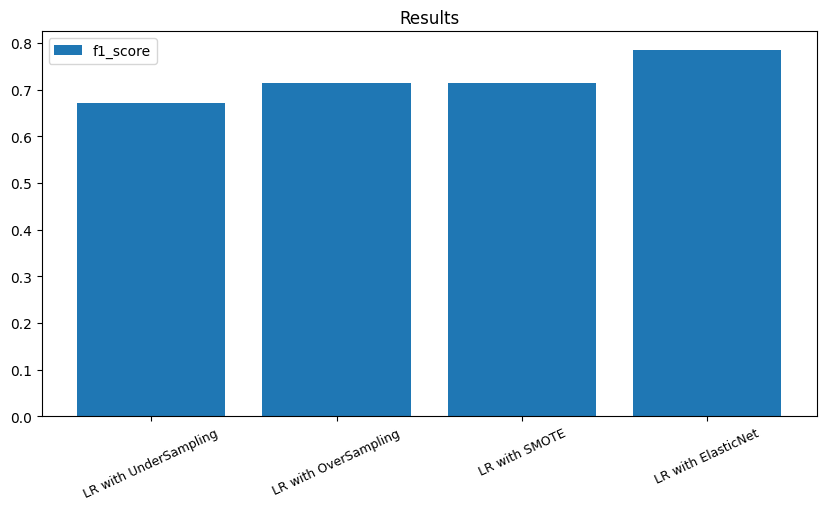

In [ ]:
results = dict(sorted(results.items(), key=lambda item: item[1]))
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), label='f1_score')
plt.title('Results')
plt.xticks(rotation=25, fontsize=9)
plt.legend()
plt.show()

Лучшее качество даёт модель Логистической регрессии с ElasticNet.

Попробуем улучшить качество её классификации, убрав слабокоррелированные с таргетом признаки:

In [ ]:
cols = X_train.columns.tolist()

for col in cols:
  X_simple_train = X_train.drop(col, axis=1)

  cv_metrics = cross_validate(
      pipeline_elasticnet,
      X=X_simple_train,
      y=y_train,
      cv=StratifiedKFold(5, shuffle=True, random_state=42),
      scoring='f1',
      n_jobs=-1
  )
  print(f'Среднее качество на валидации при удалении признака {col}: {cv_metrics["test_score"].mean():.4f}.')

Среднее качество на валидации при удалении признака age: 0.7886.
Среднее качество на валидации при удалении признака hdlngth: 0.7346.
Среднее качество на валидации при удалении признака skullw: 0.7027.
Среднее качество на валидации при удалении признака totlngth: 0.7213.
Среднее качество на валидации при удалении признака taill: 0.7853.
Среднее качество на валидации при удалении признака footlgth: 0.7853.
Среднее качество на валидации при удалении признака earconch: 0.7853.
Среднее качество на валидации при удалении признака eye: 0.7763.
Среднее качество на валидации при удалении признака chest: 0.7603.
Среднее качество на валидации при удалении признака belly: 0.7446.


С полным набором признаков результат был ~0.78. Соответственно удаление слабокоррелированных с таргетом признаков 'taill' и 'age' даёт такой же результат метрики f1_score. Всё же будем смотреть на изменение качества после сдвига порога на обоих наборах данных:

In [ ]:
X_simple_train = X_train.drop(['age', 'taill'], axis=1)
X_simple_test = X_test.drop(['age', 'taill'], axis=1)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_proba_pred = cross_val_predict(pipeline_elasticnet, X_train,
                                   y_train, cv=5, method='predict_proba')[:, 1]

y_proba_pred = pd.Series(y_proba_pred)

y_proba_pred_simple = cross_val_predict(pipeline_elasticnet, X_simple_train,
                                   y_train, cv=5, method='predict_proba')[:, 1]

y_proba_pred_simple = pd.Series(y_proba_pred_simple)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:

    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)

    recall_scores.append(recall_score(y_train, y_pred))
    precision_scores.append(precision_score(y_train, y_pred))
    f1_scores.append(f1_score(y_train, y_pred))

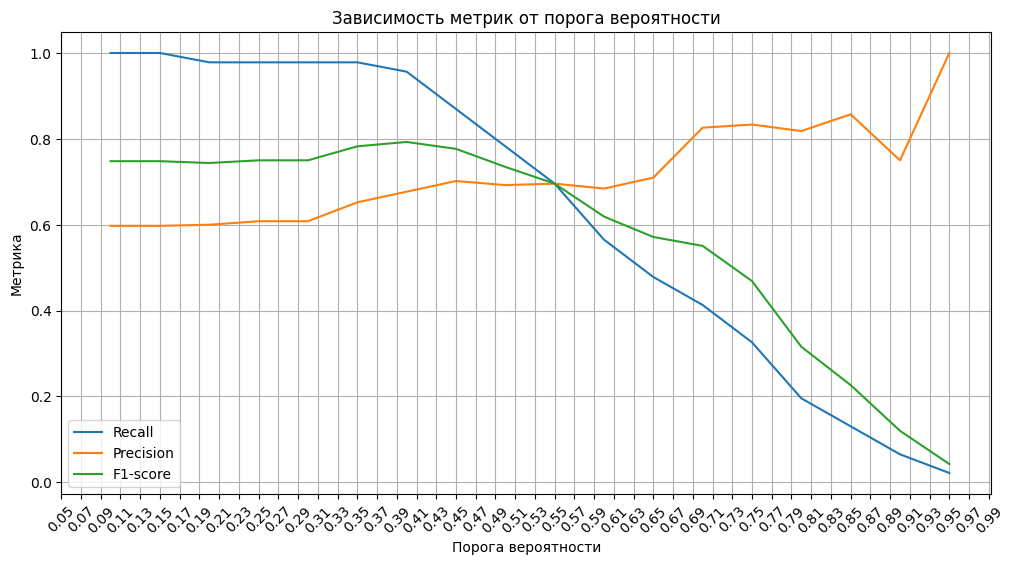

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall')

plt.plot(thresholds, precision_scores, label='Precision')

plt.plot(thresholds, f1_scores, label='F1-score')

plt.title('Зависимость метрик от порогa вероятности')
plt.xlabel('Порога вероятности')
plt.ylabel('Метрика')
plt.xticks(thresholds)
plt.xticks(np.arange(0.05, 1, 0.02), rotation=45)
plt.grid(True)
plt.legend()

Оптимальный порог для всех метрик - 0.43, так как в этой отметке значения прироста f1 и recall превышают потери по precision.

Поскольку модель одна и та же, оптимальный порог для обоих наборов данных будет идентичен.

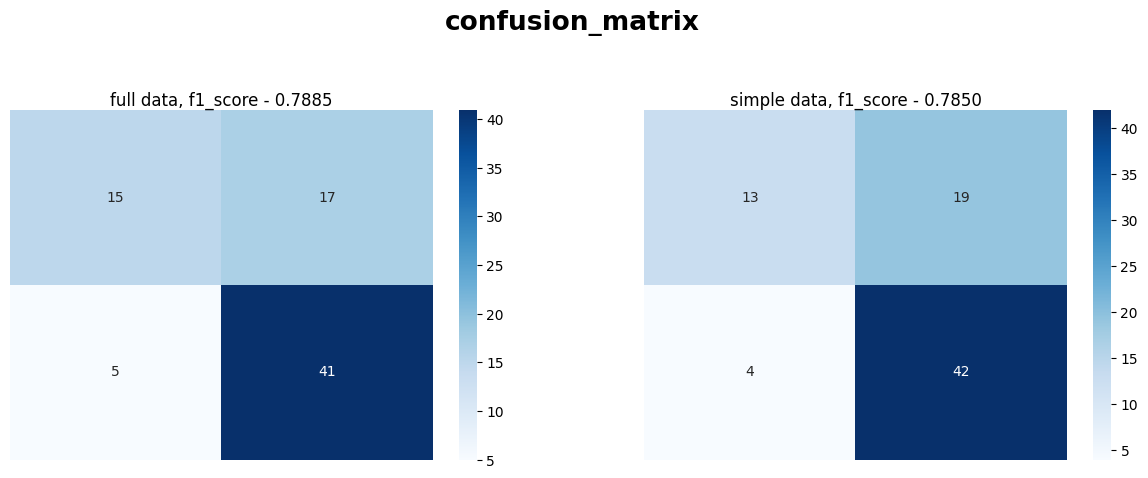

In [ ]:
opt_threshold = 0.43
y_pred = y_proba_pred.apply(lambda x: 1 if x>opt_threshold else 0)
y_pred_simple = y_proba_pred_simple.apply(lambda x: 1 if x>opt_threshold else 0)

scores = [f1_score(y_train, y_pred), f1_score(y_train, y_pred_simple)]
report = classification_report(y_train, y_pred)

report_simple = classification_report(y_train, y_pred_simple)

cols = ['full data', 'simple data']
data = [y_pred, y_pred_simple]
plt.figure(figsize=(15, 10))
plt.suptitle('confusion_matrix', fontsize=19, fontweight='bold')
for i, col in enumerate(cols):
  plt.subplot(2, 2, i+1)
  sns.heatmap(confusion_matrix(y_train, data[i]), annot=True, fmt='d', cmap='Blues')
  plt.title(f'{cols[i]}, f1_score - {scores[i]:.4f}', fontsize=12, verticalalignment='top')
  plt.axis('off')

plt.show()




Теперь проверим на тестовой выборке модель с полным набором данных, так как она даёт меньше ошибок:

f1_score на тестовых данных: 0.7568

              precision    recall  f1-score   support

           0       0.75      0.47      0.58        32
           1       0.71      0.89      0.79        46

    accuracy                           0.72        78
   macro avg       0.73      0.68      0.68        78
weighted avg       0.72      0.72      0.70        78



<Axes: >

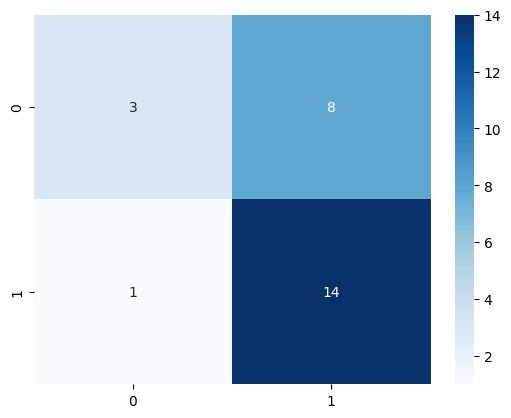

In [ ]:
pipeline_elasticnet.fit(X_train, y_train)

y_proba_pred_test = cross_val_predict(pipeline_elasticnet, X_test,
                                   y_test, cv=5, method='predict_proba')[:, 1]

y_proba_pred_test = pd.Series(y_proba_pred_test)

y_pred_test = y_proba_pred_test.apply(lambda x: 1 if x>opt_threshold else 0)
print(f'f1_score на тестовых данных: {f1_score(y_test, y_pred_test):.4f}\n')
print(report)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')

Найдем важнейшие уже на обученной модели предикторы:

In [ ]:
from sklearn.inspection import permutation_importance


# Permutation Importance
perm_importance = permutation_importance(pipeline_elasticnet, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})
print("\nPermutation Importance:")
print(perm_importance_df.sort_values(by='Importance Mean', ascending=False))


Permutation Importance:
    Feature  Importance Mean  Importance Std
1   hdlngth         0.106410        0.064880
2    skullw         0.062821        0.085706
7       eye         0.037179        0.037793
8     chest         0.010256        0.032837
9     belly         0.006410        0.037268
3  totlngth         0.006410        0.066679
0       age         0.000000        0.000000
4     taill         0.000000        0.000000
6  earconch         0.000000        0.000000
5  footlgth        -0.020513        0.030982


## Выводы по использованию Логистической регрессии

- На тестовых данных получаем 9 неравномерно распределенных ошибок (следствие дисбаланса классов).
- Лучшей моделью оказалась логистическая регрессия с регуляризацией и без использования полинома.
- Смещение порога повысило качество по f1_score.
- Удаление низкоррелированных с таргетом признаков не дало прироста в качестве модели в перспективе, показав то же качествo, если не хуже.
- Три важнейших признака для модели: "hdlngth", "skullw" и "eye".

## Теперь попробуем построить модель на DecisionTreeClassifier

In [ ]:
X = df.drop('sex', axis=1)
y = df['sex']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, random_state=42)

Переберём гиперпараметры с помощью HyperOpt:

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
results_tree = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
degree_map = [1, 2, 3]
max_depth_map = range(1, 12)
min_samples_leaf_map = range(3, 20)
min_samples_split_map = range(2, 6)
class_map = ['balanced']

space = {
    'decisiontreeclassifier__max_depth': hp.choice('decisiontreeclassifier__max_depth', max_depth_map),
    'decisiontreeclassifier__min_samples_split': hp.choice('decisiontreeclassifier__min_samples_split', min_samples_split_map),
    'decisiontreeclassifier__min_samples_leaf': hp.choice('decisiontreeclassifier__min_samples_leaf', min_samples_leaf_map),
    'decisiontreeclassifier__class_weight': hp.choice('decisiontreeclassifier__class_weight', class_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_tree = make_pipeline(
    PolynomialFeatures(include_bias=False),
    DecisionTreeClassifier(random_state=42)
)

def objective(params):
    pipeline_tree.set_params(decisiontreeclassifier__max_depth=params['decisiontreeclassifier__max_depth'],
                        decisiontreeclassifier__min_samples_split=params['decisiontreeclassifier__min_samples_split'],
                           decisiontreeclassifier__min_samples_leaf=params['decisiontreeclassifier__min_samples_leaf'],
                             decisiontreeclassifier__class_weight=params['decisiontreeclassifier__class_weight'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_tree, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_tree = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=350,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_tree)

100%|██████████| 350/350 [00:43<00:00,  8.10trial/s, best loss: -0.6879023646071701]
Лучшие гиперпараметры: {'decisiontreeclassifier__class_weight': np.int64(0), 'decisiontreeclassifier__max_depth': np.int64(2), 'decisiontreeclassifier__min_samples_leaf': np.int64(5), 'decisiontreeclassifier__min_samples_split': np.int64(3), 'polynomialfeatures__degree': np.int64(2)}
CPU times: user 7.79 s, sys: 395 ms, total: 8.19 s
Wall time: 43.2 s


In [ ]:
%%time

pipeline_tree = make_pipeline(
    PolynomialFeatures(include_bias=False),
    DecisionTreeClassifier(random_state=42)
)

# зафиксируем результат в словаре results
pipeline_tree.set_params(decisiontreeclassifier__max_depth=max_depth_map[best_tree['decisiontreeclassifier__max_depth']],
                    decisiontreeclassifier__min_samples_leaf=min_samples_leaf_map[best_tree['decisiontreeclassifier__min_samples_leaf']],
                      decisiontreeclassifier__min_samples_split=min_samples_split_map[best_tree['decisiontreeclassifier__min_samples_split']],
                          decisiontreeclassifier__class_weight=class_map[best_tree['decisiontreeclassifier__class_weight']],
                      polynomialfeatures__degree=degree_map[best_tree['polynomialfeatures__degree']])

cv_metrics = cross_validate(
    pipeline_tree,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results_tree['Tree'] = cv_metrics["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.6879.
CPU times: user 13.9 ms, sys: 1.94 ms, total: 15.9 ms
Wall time: 72.9 ms


              precision    recall  f1-score   support

           0       0.55      0.50      0.52        32
           1       0.67      0.72      0.69        46

    accuracy                           0.63        78
   macro avg       0.61      0.61      0.61        78
weighted avg       0.62      0.63      0.62        78



<Axes: >

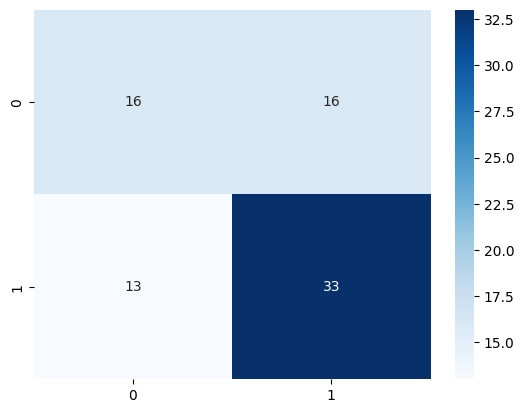

In [ ]:
y_pred = cross_val_predict(pipeline_tree, X_train, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Ошибки распределены иначе, чем у логистической регрессии из-за взвешивания классов. Но пока результат хуже достигнутого ранее, попробуем убрать из данных самые незначительные признаки:

Оценим важность признаков, чтобы убрать неважные и тем самым улучшить качество модели. Для этого применим два способа - Recursive Feature elimination и ermutation_importance:

In [ ]:
from sklearn.feature_selection import RFECV
feature_names = df.columns.tolist()
pipeline_tree.fit(X_train, y_train)

selected_feature_names = []

# Создаем экземпляр RFECV
rfecv = RFECV(estimator=pipeline_tree[-1], step=5, cv=skf, scoring='f1')

# Обучение RFECV на предварительно обработанных данных
rfecv.fit(X_train, y_train)

# Получение отобранных признаков
selected_features = np.where(rfecv.support_)[0]

[selected_feature_names.append(feature_names[x]) for x in selected_features]
feature_importances = rfecv.estimator_.feature_importances_

# Вывод отобранных признаков и их важности
print("Отобранные признаки и их важность:")
for feature_name, importance in zip(selected_feature_names, feature_importances):
    print(f'Признак: {feature_name}, Важность: {importance:.4f}')

Отобранные признаки и их важность:
Признак: hdlngth, Важность: 0.2611
Признак: skullw, Важность: 0.3037
Признак: taill, Важность: 0.1710
Признак: footlgth, Важность: 0.1461
Признак: eye, Важность: 0.1182


In [ ]:
pipeline_tree.fit(X_train, y_train)

perm_importance_tree = permutation_importance(pipeline_tree, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df_tree = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': perm_importance_tree.importances_mean,
    'Importance Std': perm_importance_tree.importances_std
})
print("\nPermutation Importance:")
print(perm_importance_df_tree.sort_values(by='Importance Mean', ascending=False))


Permutation Importance:
    Feature  Importance Mean  Importance Std
1   hdlngth         0.067949        0.038053
2    skullw         0.015385        0.067791
0       age         0.000000        0.000000
4     taill         0.000000        0.000000
7       eye         0.000000        0.000000
6  earconch         0.000000        0.000000
8     chest         0.000000        0.000000
9     belly         0.000000        0.000000
3  totlngth        -0.073077        0.066134
5  footlgth        -0.075641        0.057464


Способы дали местами противоречивую картину, однако в обоих случаях age, chest и belly не являются хоть сколько то важными, поэтому удаляем именно их.

In [ ]:
X_train_simple = X_train[['age', 'belly', 'chest']]
X_test_simple = X_test[['age', 'belly', 'chest']]

In [ ]:
%%time
degree_map = [1, 2, 3]
max_depth_map = range(1, 12)
min_samples_leaf_map = range(1, 20)
min_samples_split_map = range(2, 6)
class_map = [None, 'balanced']

space = {
    'decisiontreeclassifier__max_depth': hp.choice('decisiontreeclassifier__max_depth', max_depth_map),
    'decisiontreeclassifier__min_samples_split': hp.choice('decisiontreeclassifier__min_samples_split', min_samples_split_map),
    'decisiontreeclassifier__min_samples_leaf': hp.choice('decisiontreeclassifier__min_samples_leaf', min_samples_leaf_map),
    'decisiontreeclassifier__class_weight': hp.choice('decisiontreeclassifier__class_weight', class_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_tree_simple = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(include_bias=False),
    DecisionTreeClassifier(random_state=42)
)

def objective(params):
    pipeline_tree_simple.set_params(decisiontreeclassifier__max_depth=params['decisiontreeclassifier__max_depth'],
                        decisiontreeclassifier__min_samples_split=params['decisiontreeclassifier__min_samples_split'],
                           decisiontreeclassifier__min_samples_leaf=params['decisiontreeclassifier__min_samples_leaf'],
                             decisiontreeclassifier__class_weight=params['decisiontreeclassifier__class_weight'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_tree_simple, X_train_simple, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_tree_simple = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=400,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_tree_simple)

100%|██████████| 400/400 [00:36<00:00, 10.91trial/s, best loss: -0.7183333333333334]
Лучшие гиперпараметры: {'decisiontreeclassifier__class_weight': np.int64(0), 'decisiontreeclassifier__max_depth': np.int64(2), 'decisiontreeclassifier__min_samples_leaf': np.int64(0), 'decisiontreeclassifier__min_samples_split': np.int64(1), 'polynomialfeatures__degree': np.int64(0)}
CPU times: user 9.28 s, sys: 364 ms, total: 9.64 s
Wall time: 36.7 s


Прирост по качеству заметен.

In [ ]:
%%time

pipeline_tree_simple = make_pipeline(
    PolynomialFeatures(include_bias=False),
    DecisionTreeClassifier(random_state=42)
)

# зафиксируем результат в словаре results
pipeline_tree_simple.set_params(decisiontreeclassifier__max_depth=max_depth_map[best_tree_simple['decisiontreeclassifier__max_depth']],
                    decisiontreeclassifier__min_samples_leaf=min_samples_leaf_map[best_tree_simple['decisiontreeclassifier__min_samples_leaf']],
                      decisiontreeclassifier__min_samples_split=min_samples_split_map[best_tree_simple['decisiontreeclassifier__min_samples_split']],
                          decisiontreeclassifier__class_weight=class_map[best_tree_simple['decisiontreeclassifier__class_weight']],
                      polynomialfeatures__degree=degree_map[best_tree_simple['polynomialfeatures__degree']])

cv_metrics_simple = cross_validate(
    pipeline_tree_simple,
    X=X_train_simple,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results_tree['Tree simple features with weight balanced'] = cv_metrics_simple["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics_simple["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.7183.
CPU times: user 30.2 ms, sys: 46.8 ms, total: 77 ms
Wall time: 2.35 s


Теперь смотрим OverSampling (UnderSampling в условиях такого малого кол-ва данных не подходит, это мы уже наблюдали при использовании его с логистической регрессией)

In [ ]:
%%time

degree_map = [1, 2, 3]
max_depth_map = range(1, 12)
min_samples_leaf_map = range(1, 20)
min_samples_split_map = range(2, 6)

space = {
    'decisiontreeclassifier__max_depth': hp.choice('decisiontreeclassifier__max_depth', max_depth_map),
    'decisiontreeclassifier__min_samples_split': hp.choice('decisiontreeclassifier__min_samples_split', min_samples_split_map),
    'decisiontreeclassifier__min_samples_leaf': hp.choice('decisiontreeclassifier__min_samples_leaf', min_samples_leaf_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_tree_os = make_pipeline(
    PolynomialFeatures(include_bias=False),
    RandomOverSampler(random_state=42),
    DecisionTreeClassifier(random_state=42)
)

def objective(params):
    pipeline_tree_os.set_params(decisiontreeclassifier__max_depth=params['decisiontreeclassifier__max_depth'],
                        decisiontreeclassifier__min_samples_split=params['decisiontreeclassifier__min_samples_split'],
                           decisiontreeclassifier__min_samples_leaf=params['decisiontreeclassifier__min_samples_leaf'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_tree_os, X_train_simple, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_tree_os = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_tree_os)

100%|██████████| 300/300 [00:28<00:00, 10.36trial/s, best loss: -0.6526315789473685]
Лучшие гиперпараметры: {'decisiontreeclassifier__max_depth': np.int64(7), 'decisiontreeclassifier__min_samples_leaf': np.int64(13), 'decisiontreeclassifier__min_samples_split': np.int64(2), 'polynomialfeatures__degree': np.int64(0)}
CPU times: user 6.65 s, sys: 291 ms, total: 6.94 s
Wall time: 29 s


In [ ]:
%%time

pipeline_tree_os = make_pipeline(
    PolynomialFeatures(include_bias=False),
    RandomOverSampler(random_state=42),
    DecisionTreeClassifier(random_state=42)
)

# зафиксируем результат в словаре results
pipeline_tree_os.set_params(decisiontreeclassifier__max_depth=max_depth_map[best_tree_os['decisiontreeclassifier__max_depth']],
                    decisiontreeclassifier__min_samples_leaf=min_samples_leaf_map[best_tree_os['decisiontreeclassifier__min_samples_leaf']],
                      decisiontreeclassifier__min_samples_split=min_samples_split_map[best_tree_os['decisiontreeclassifier__min_samples_split']],
                      polynomialfeatures__degree=degree_map[best_tree_os['polynomialfeatures__degree']])

cv_metrics_os = cross_validate(
    pipeline_tree_os,
    X=X_train_simple,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results_tree['Tree with OverSampling'] = cv_metrics_os["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics_os["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.6526.
CPU times: user 43.9 ms, sys: 46.6 ms, total: 90.5 ms
Wall time: 3.3 s


Качество на кросс-валидации ухудшилось.

Попробуем SMOTE:

In [ ]:
%%time

degree_map = [1, 2, 3]
max_depth_map = range(1, 11)
min_samples_leaf_map = range(1, 17)
min_samples_split_map = range(2, 6)
k_neighbors_map = range(1, 6)

space = {
    'decisiontreeclassifier__max_depth': hp.choice('decisiontreeclassifier__max_depth', max_depth_map),
    'decisiontreeclassifier__min_samples_split': hp.choice('decisiontreeclassifier__min_samples_split', min_samples_split_map),
    'decisiontreeclassifier__min_samples_leaf': hp.choice('decisiontreeclassifier__min_samples_leaf', min_samples_leaf_map),
    'smote__k_neighbors': hp.choice('smote__k_neighbors', k_neighbors_map),
    'polynomialfeatures__degree': hp.choice('polynomialfeatures__degree', degree_map)}

pipeline_tree_smote = make_pipeline(
    PolynomialFeatures(include_bias=False),
    SMOTE(random_state=42),
    DecisionTreeClassifier(random_state=42)
)

def objective(params):
    pipeline_tree_smote.set_params(decisiontreeclassifier__max_depth=params['decisiontreeclassifier__max_depth'],
                        decisiontreeclassifier__min_samples_split=params['decisiontreeclassifier__min_samples_split'],
                           decisiontreeclassifier__min_samples_leaf=params['decisiontreeclassifier__min_samples_leaf'],
                                smote__k_neighbors=params['smote__k_neighbors'],
                        polynomialfeatures__degree=params['polynomialfeatures__degree'])

    cv_results = cross_validate(pipeline_tree_smote, X_train_simple, y_train, cv=skf, scoring='f1', n_jobs=-1, return_train_score=True)

    return {'loss': -np.mean(cv_results['test_score']), 'params': params, 'status': STATUS_OK}

trials = Trials()
best_tree_smote = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Лучшие гиперпараметры:", best_tree_smote)

100%|██████████| 300/300 [00:29<00:00, 10.11trial/s, best loss: -0.6885038683665685]
Лучшие гиперпараметры: {'decisiontreeclassifier__max_depth': np.int64(3), 'decisiontreeclassifier__min_samples_leaf': np.int64(13), 'decisiontreeclassifier__min_samples_split': np.int64(0), 'polynomialfeatures__degree': np.int64(0), 'smote__k_neighbors': np.int64(0)}
CPU times: user 6.86 s, sys: 296 ms, total: 7.16 s
Wall time: 29.7 s


In [ ]:
%%time

pipeline_tree_smote = make_pipeline(
    PolynomialFeatures(include_bias=False),
    SMOTE(random_state=42),
    DecisionTreeClassifier(random_state=42)
)

# зафиксируем результат в словаре results
pipeline_tree_smote.set_params(decisiontreeclassifier__max_depth=max_depth_map[best_tree_smote['decisiontreeclassifier__max_depth']],
                    decisiontreeclassifier__min_samples_leaf=min_samples_leaf_map[best_tree_smote['decisiontreeclassifier__min_samples_leaf']],
                      decisiontreeclassifier__min_samples_split=min_samples_split_map[best_tree_smote['decisiontreeclassifier__min_samples_split']],
                      polynomialfeatures__degree=degree_map[best_tree_smote['polynomialfeatures__degree']])

cv_metrics_smote = cross_validate(
    pipeline_tree_smote,
    X=X_train_simple,
    y=y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
results_tree['Tree with SMOTE'] = cv_metrics_smote["test_score"].mean()
print(f'Среднее качество на валидации: {cv_metrics_smote["test_score"].mean():.4f}.')

Среднее качество на валидации: 0.6795.
CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 68.6 ms


Немного лучше обычного OverSampling.

Таблица результатов:

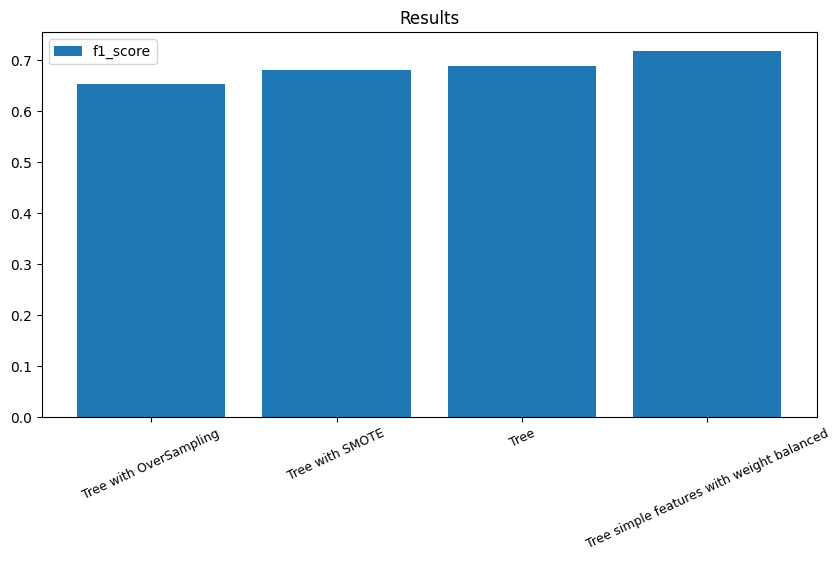

In [ ]:
results = dict(sorted(results_tree.items(), key=lambda item: item[1]))
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), label='f1_score')
plt.title('Results')
plt.xticks(rotation=25, fontsize=9)
plt.legend()
plt.show()

Лучшая модель - с балансом весов.

Посмотрим распредление ее ошибок:

              precision    recall  f1-score   support

           0       0.58      0.47      0.52        32
           1       0.67      0.76      0.71        46

    accuracy                           0.64        78
   macro avg       0.62      0.61      0.62        78
weighted avg       0.63      0.64      0.63        78



<Axes: >

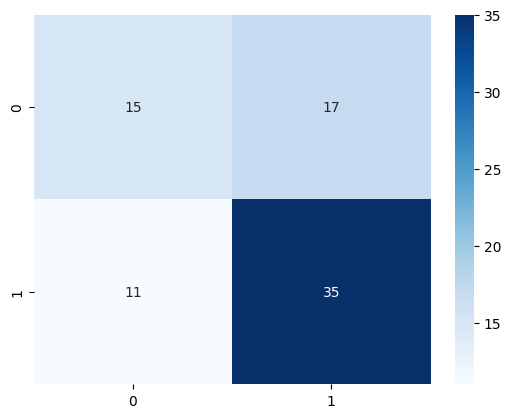

In [ ]:
y_pred = cross_val_predict(pipeline_tree_simple, X_train_simple, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Распределение неравномерно вследствие дисбаланса классов в данных.

На тестовой выборке:

Качество на тесте: 0.7586206896551724

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.79      0.73      0.76        15

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26



<Axes: >

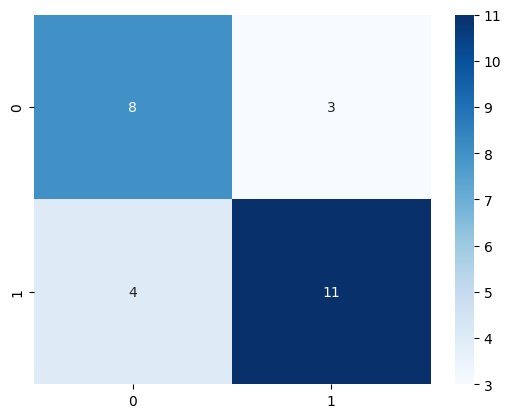

In [ ]:
pipeline_tree_os.fit(X_train_simple, y_train)
y_pred_tests = cross_val_predict(pipeline_tree_simple, X_test_simple, y_test, cv=skf, n_jobs=-1)
print(f'Качество на тесте: {f1_score(y_test, y_pred_tests)}\n')
report = classification_report(y_test, y_pred_tests)
print(report)

sns.heatmap(confusion_matrix(y_test, y_pred_tests), annot=True, fmt='d', cmap='Blues')

## Выводы:

1.   Самые неважные признаки для модели решающего дерева: 'age', 'belly', 'chest'.
2.   Самые важные: 'hdlngth', 'skullw' и 'taill'.
3.   Качество на тесте у моделей дерева и логистической регресии почти не отличается и составляет ~0.76.
4.   С балансом весов в случае модели решающего дерева ошибки распределилось более менее одинаково на тестовых данных, чего не скажешь об ошибках модели логистической регрессии, где они почти все первого рода и их больше на две, чем у DecisionTree.

